In [1]:
from src.utils import gallery_specs, gallery_notations
from src.tokens import load_tokens
import random
from src.distances import dmat_and_order
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'



In [2]:
gallery = "libra-int-only"
distance = "cd"

In [3]:
all_specs = gallery_specs(gallery)
tokens = load_tokens()

In [4]:
random.seed(42)
notations = []
dispersion = []
size = []
vocab = []
for i in range(1_000):
  sample = random.choices(all_specs, k=len(all_specs))
  for notation in gallery_notations(gallery):
    notations.append(notation)
    dmat_sym, order = dmat_and_order(gallery, notation, distance)
    sample_idx = np.array([order.index(s) for s in sample])
    dispersion.append(np.median(dmat_sym[sample_idx][:,sample_idx]))
    dmat_sym, order = dmat_and_order(gallery, notation, "from_length")
    size.append(np.median(dmat_sym[sample_idx][:,sample_idx]))
    vocab.append(tokens.query("gallery == @gallery and notation == @notation and spec in @sample")["token"].nunique())
df = pd.DataFrame(dict(dispersion=dispersion, vocab=vocab, notation=notations, size=size))

TypeError: 'tuple' object does not support item assignment

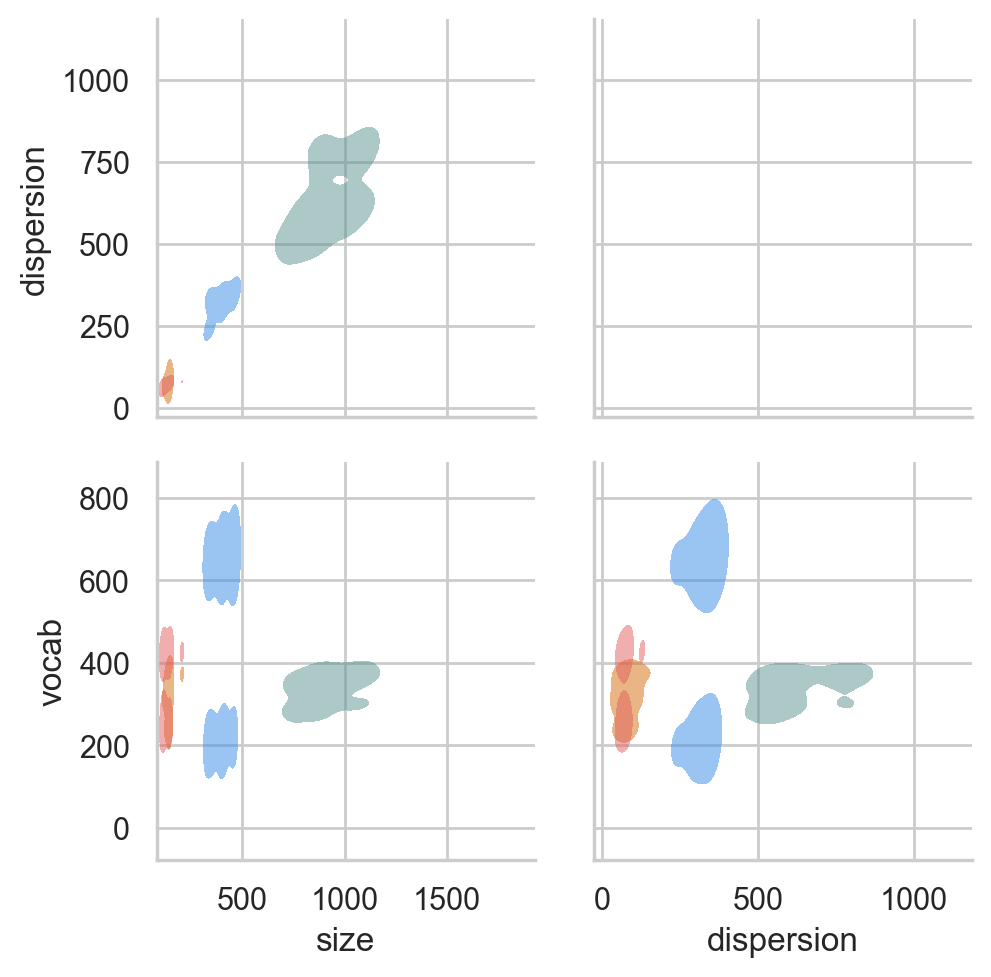

In [22]:
# Define custom color palette
notation_colors = {
    'd3': '#1F5997',
    'vega': '#72B7B2',
    'libra_d3': '#E77608',
    'libra_vega': '#E45756'
}

sns.set_theme(style="whitegrid", palette="deep")

g = sns.PairGrid(df, hue="notation", x_vars=["size", "dispersion"], y_vars=["dispersion", "vocab"],
                 palette=notation_colors)

# First create KDE plots with custom styling
g.map(sns.kdeplot, common_norm=False, levels=[0.25, 1], warn_singular=False,  # added more levels
      alpha=0.5, color='black',  # stroke settings
      fill=True)  # fill settings

# Store the current axis limits
xlims = [ax.get_xlim() for ax in g.axes.flat if ax is not None]
ylims = [ax.get_ylim() for ax in g.axes.flat if ax is not None]

# Add scatter plots with custom styling
g.map(sns.scatterplot, s=1, alpha=0.7, linewidth=0)  # size=1, no stroke, 0.7 opacity

# Restore the original limits from KDE plots
for ax, xlim, ylim in zip([ax for ax in g.axes.flat if ax is not None], xlims, ylims):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

g.axes[0,1].set_visible(False)
g.add_legend(loc=(0.7,0.7))
g.fig.set_figheight(10)
g.fig.set_figwidth(15)

In [19]:
g.savefig("../figs/threeway.svg")
g.savefig("../figs/threeway.pdf")


In [20]:
df2 = df.groupby("notation").agg(["mean", "std"]).reset_index()
df2.columns = ['_'.join(col) for col in df2.columns.values]


In [21]:
fig = px.scatter(df2, x="vocab_mean", y="dispersion_mean", error_x="vocab_std", error_y="dispersion_std", color="notation_", width=800, height=800)
fig.update_layout(xaxis_rangemode="tozero", yaxis_rangemode="tozero")